# Movie rating Recommendation system

## Business and Data Understanding

## Data Preparartion

 I'll start by inspecting the contents of these files to understand their structure and proceed with building the movie recommendation system.

In this project, we have 3 seperate datasets
* Links dataset
* Movies dataset
* Ratings dataset

In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans

In [3]:
links_df = pd.read_csv('./ml-latest-small/links.csv')
movies_df = pd.read_csv('./ml-latest-small/movies.csv')
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv')


In [4]:
# print the head of each dataset

links_df_head = links_df.head()
movies_df_head = movies_df.head()
ratings_df_head = ratings_df.head()

links_df_head, movies_df_head, ratings_df_head

(   movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50  

Here is the structure of the three datasets:

    1. Links Dataset (links.csv):
        * movieId: A unique identifier for each movie (linked to the movies.csv dataset).
        * imdbId: The IMDb ID for the movie.
        * tmdbId: The TMDb ID for the movie.
     
    2. Movies Dataset (movies.csv):
    
        * movieId: A unique identifier for each movie (linked to the ratings.csv and links.csv datasets).
        * title: The title of the movie, including the release year.
        * genres: The genres associated with the movie (separated by "|").

    3.Ratings Dataset (ratings.csv):

        * userId: A unique identifier for each user.
        * movieId: A unique identifier for the movie (linked to the movies.csv dataset).
        * rating: The rating given by the user (on a scale, e.g., 1 to 5).
        * timestamp: The timestamp of when the rating was given.

## EDA

I'll focus on the following for EDA:

    1. Missing Values: Check for null or missing values in each dataset.
    
    2. Distribution of Ratings: Analyze the distribution of ratings to understand user behavior.
    
    3. Movie Statistics: Identify the most-rated and least-rated movies.
    
    4. User Statistics: Understand user activity (e.g., number of movies rated per user).
    
    5. Genre Analysis: Explore the genres of movies to see the diversity in the dataset.

In [5]:
# Check for missing values in each dataset

missing_links = links_df.isnull().sum()

missing_movies = movies_df.isnull().sum()

missing_ratings = ratings_df.isnull().sum()



missing_links, missing_movies, missing_ratings

(movieId    0
 imdbId     0
 tmdbId     8
 dtype: int64,
 movieId    0
 title      0
 genres     0
 dtype: int64,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64)

We see  the missing values in the following

    Links Dataset:
        tmdbId: 8 missing values.
We can drop these values since it's a small portion of missing values throughout the data

In [6]:
links_df.dropna(subset=['tmdbId'], inplace=True)

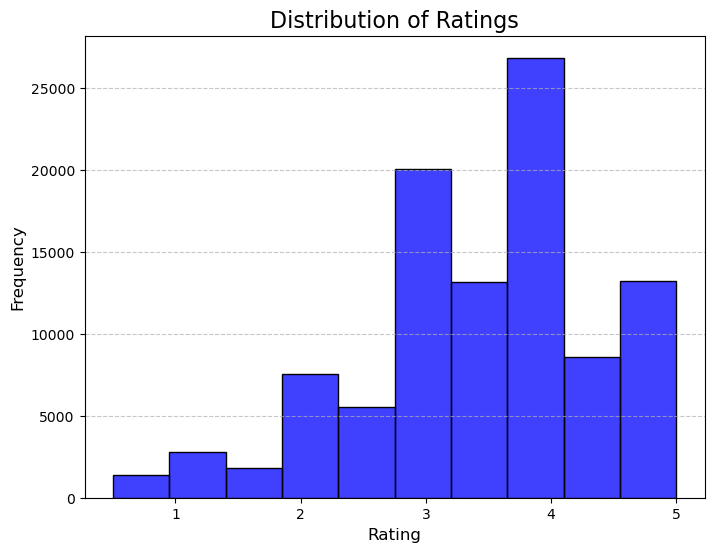

In [7]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=False, color='blue')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The distribution of ratings shows clear peaks at rounded values (e.g., 3.0, 4.0, 5.0), suggesting users prefer whole-number ratings. The majority of ratings seem to lean towards higher values, indicating that users may tend to rate movies positively.

In [8]:
# Movie statistics: Number of ratings per movie
movie_rating_counts = ratings_df['movieId'].value_counts()
most_rated_movies = movie_rating_counts.head(5)
least_rated_movies = movie_rating_counts.tail(5)

# Merge with movies_df to get movie titles for the most/least-rated movies
most_rated_movies_df = movies_df[movies_df['movieId'].isin(most_rated_movies.index)]
most_rated_movies_df = most_rated_movies_df.set_index('movieId').loc[most_rated_movies.index]
most_rated_movies_df['rating_count'] = most_rated_movies.values

#Least-rated movies
least_rated_movies_df = movies_df[movies_df['movieId'].isin(least_rated_movies.index)]
least_rated_movies_df = least_rated_movies_df.set_index('movieId').loc[least_rated_movies.index]
least_rated_movies_df['rating_count'] = least_rated_movies.values

print('Most Rated Movies:')
print(most_rated_movies_df)

print('\n Least Rated Movies:')
print(least_rated_movies_df)


Most Rated Movies:
                                    title                       genres  \
movieId                                                                  
356                   Forrest Gump (1994)     Comedy|Drama|Romance|War   
318      Shawshank Redemption, The (1994)                  Crime|Drama   
296                   Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller   
593      Silence of the Lambs, The (1991)        Crime|Horror|Thriller   
2571                   Matrix, The (1999)       Action|Sci-Fi|Thriller   

         rating_count  
movieId                
356               329  
318               317  
296               307  
593               279  
2571              278  

 Least Rated Movies:
                                               title          genres  \
movieId                                                                
86279                           Into Eternity (2010)     Documentary   
86922    Nothing to Declare (Rien à déclarer) (2010)    

Let's visualize the Top 5 Most rated Movies

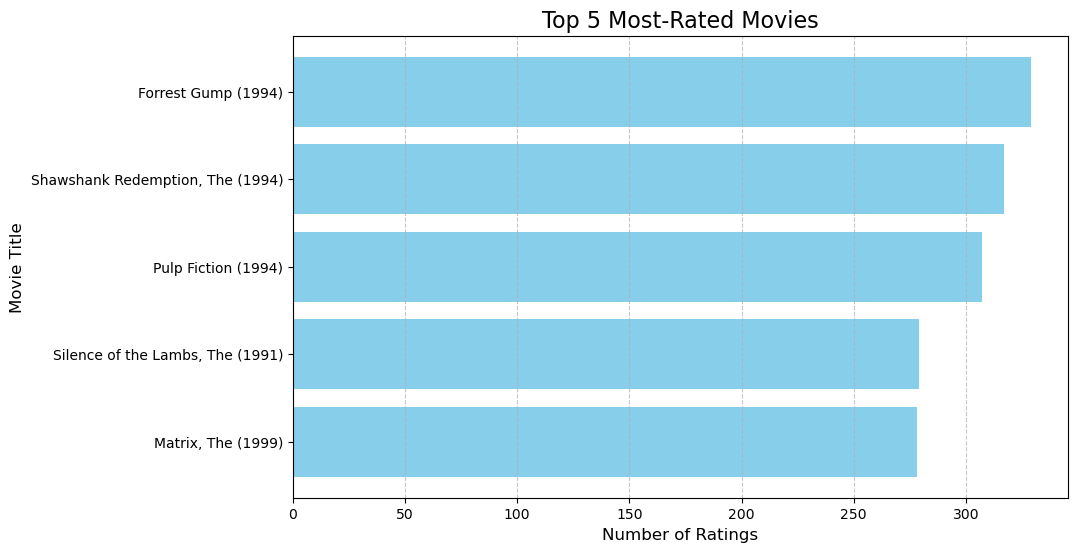

In [9]:
# Plot most-rated movies
plt.figure(figsize=(10, 6))
plt.barh(most_rated_movies_df['title'], most_rated_movies_df['rating_count'], color='skyblue')
plt.title('Top 5 Most-Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the most-rated movie on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Let's do the same with the 5 least rated movies

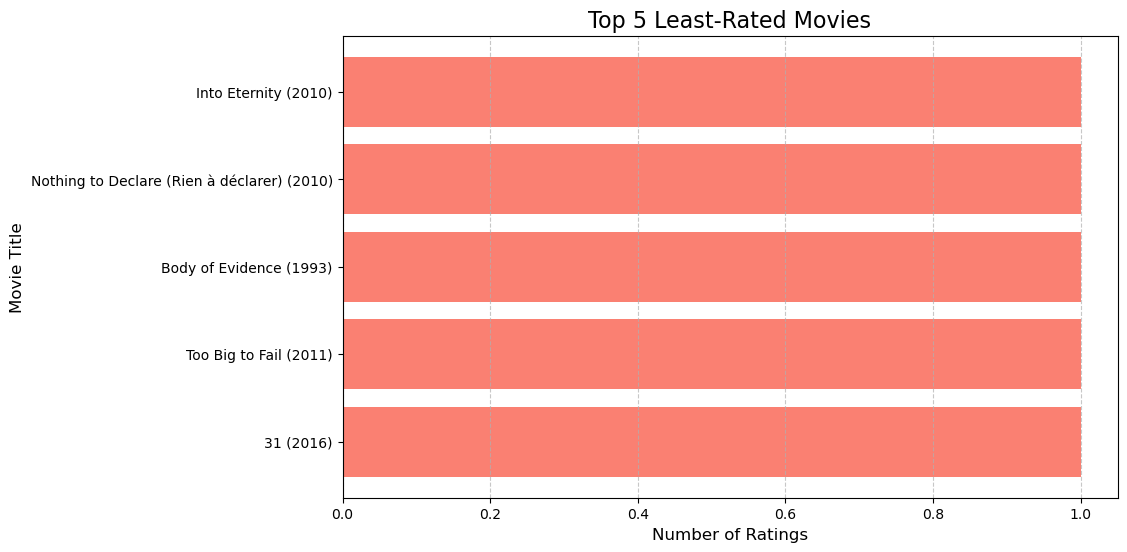

In [10]:
# Plot least-rated movies
plt.figure(figsize=(10, 6))
plt.barh(least_rated_movies_df['title'], least_rated_movies_df['rating_count'], color='salmon')
plt.title('Top 5 Least-Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the least-rated movie on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### Explore User Statistics

Next lets focus on the Most and Least active users based on how many ratings they have provided.

In [11]:
# Count the number of ratings per user
user_rating_counts = ratings_df['userId'].value_counts()

# Get the most active users
most_active_users = user_rating_counts.head()

# Get the least active users
least_active_users = user_rating_counts.tail()

#print results
print('Most Active Users:')
print(most_active_users)

print('\n Least Active Users:')
print(least_rated_movies_df)

Most Active Users:
userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: count, dtype: int64

 Least Active Users:
                                               title          genres  \
movieId                                                                
86279                           Into Eternity (2010)     Documentary   
86922    Nothing to Declare (Rien à déclarer) (2010)          Comedy   
5962                         Body of Evidence (1993)  Drama|Thriller   
87660                         Too Big to Fail (2011)           Drama   
163981                                     31 (2016)          Horror   

         rating_count  
movieId                
86279               1  
86922               1  
5962                1  
87660               1  
163981              1  


Let's continue by creating a Collaborative Filtering-based Recommendation System.

I'll preprocess the data doing the following:

* Create a user-item matrix where rows represent users, columns represent movies, and cells contain ratings.
* Normalize ratings (optional, depending on the algorithm used).
* Handle sparsity (e.g., fill missing values with 0 or leave as NaN, depending on the algorithm).

In [12]:
# create a user-item matrix
user_item_matrix =  ratings_df.pivot_table(index='userId', columns='movieId', values='rating')

# Display the matrix
print(user_item_matrix.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     N

The user-item generated matrix is sparse. Let's attempt to handle this sparsity and building the recommendation model.

Since the user-item matrix contains **NaN** value for unrated movies, let's factorize the user-item matrix to uncover latent features

In [13]:
# prepare the dataset for Surprise
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# show the amount of users and items in the dataset.
dataset = data.build_full_trainset()
print(f'Number of users: {dataset.n_users} \n')
print(f'Number of items: {dataset.n_items}')

Number of users: 610 

Number of items: 9724


## Determine the best model

Lets determine the best model for the dataset. We'll start with GridSearchCV below.

In [14]:
param_grid = {
    #latent factors
    'n_factors': [50,100,150],
    #number of iterations
    'n_epochs': [10,20,30],
    #learning rate
    'lr_all': [0.002,0.005,0.01],
    #regularization
    'reg_all': [0.02,0.1,0.2]
}

In [15]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(data)

print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8547499466032313, 'mae': 0.6558460411033349}
{'rmse': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}, 'mae': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}}


#### Cross Validation with KNNBasic

In [16]:
knn_basic = KNNBasic(sim_options={'names': 'cosine', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

for i in cv_knn_basic.items():
    print(i)

print()
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.94484286, 0.94502159, 0.95593618, 0.94962307, 0.93991013]))
('test_mae', array([0.7255003 , 0.72604704, 0.73109775, 0.72606651, 0.72121503]))
('fit_time', (0.13088679313659668, 0.12969160079956055, 0.12718820571899414, 0.12650012969970703, 0.1329963207244873))
('test_time', (0.9209954738616943, 0.9533829689025879, 0.9389417171478271, 0.9128038883209229, 0.9071307182312012))

0.9470667672099747


In [17]:
knn_basic_pearson = KNNBasic(sim_options={'name':'pearson', 'user_based': True})

cv_knn_basic_pearson = cross_validate(knn_basic_pearson, data, n_jobs=-1)

for i in cv_knn_basic_pearson.items():
    print(i)
    
print()
print(np.mean(cv_knn_basic_pearson['test_rmse']))

('test_rmse', array([0.96939432, 0.96809495, 0.98179603, 0.97498105, 0.97530301]))
('test_mae', array([0.74752846, 0.74823895, 0.75934236, 0.75280616, 0.75403154]))
('fit_time', (0.37288904190063477, 0.4414346218109131, 0.4581410884857178, 0.440915584564209, 0.3714933395385742))
('test_time', (0.9464912414550781, 0.921255350112915, 0.9130582809448242, 0.9801807403564453, 0.9149966239929199))

0.9739138737960792


#### Cross validation with KNNBaseline

In [18]:
knn_baseline = KNNBaseline(sim_options={'name': 'cosine', 'user_based': True})

cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [19]:
knn_baseline_pearson = KNNBaseline(sim_options={'name':'pearson', 'user_based': True})

cv_knn_baseline_pearson = cross_validate(knn_baseline_pearson, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [20]:
for i in cv_knn_baseline.items():
    print(i)
print('----------------------------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.88063682, 0.87716654, 0.87843907, 0.87719131, 0.87810236]))
('test_mae', array([0.67011751, 0.67476695, 0.67204122, 0.67114001, 0.67246089]))
('fit_time', (0.4084775447845459, 0.446521520614624, 0.47428441047668457, 0.45665645599365234, 0.4395463466644287))
('test_time', (1.27067232131958, 1.1849606037139893, 1.2866003513336182, 1.20798659324646, 1.327073097229004))
----------------------------------------
0.8783072221391286


In [21]:
for i in cv_knn_baseline_pearson.items():
    print(i)
print('----------------------------------------')
print(np.mean(cv_knn_baseline_pearson['test_rmse']))

('test_rmse', array([0.87797803, 0.87436908, 0.88585734, 0.86886466, 0.87944331]))
('test_mae', array([0.67343568, 0.66575967, 0.67716145, 0.66372586, 0.67005082]))
('fit_time', (0.47870445251464844, 0.4776735305786133, 0.6531095504760742, 0.5040726661682129, 0.5411410331726074))
('test_time', (1.173025131225586, 1.329312801361084, 1.141789197921753, 1.2670128345489502, 1.1369962692260742))
----------------------------------------
0.8773024836866139


## Modeling

##### Making simple prediction

In [22]:
best_rmse = gs.best_score['rmse']
best_params = gs.best_params['rmse']

# split into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=36)

In [23]:
basic = KNNBasic(sim_options={'name':'cosine', 'user_based': True})
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [24]:
basic.sim

array([[1.        , 0.9587061 , 0.9474008 , ..., 0.98802041, 0.99439606,
        1.        ],
       [0.9587061 , 1.        , 0.95702667, ..., 0.98976241, 0.97523262,
        0.98571151],
       [0.9474008 , 0.95702667, 1.        , ..., 0.97394042, 0.94332936,
        0.99466111],
       ...,
       [0.98802041, 0.98976241, 0.97394042, ..., 1.        , 0.        ,
        0.        ],
       [0.99439606, 0.97523262, 0.94332936, ..., 0.        , 1.        ,
        0.96152395],
       [1.        , 0.98571151, 0.99466111, ..., 0.        , 0.96152395,
        1.        ]])

In [25]:
predictions = basic.test(testset)

In [26]:
print(accuracy.rmse(predictions))

RMSE: 0.9761
0.9760553922765104


In [27]:
basic_pearson = KNNBasic(sim_options={'name':'pearson', 'user_based': True})
basic_pearson.fit(trainset)
pearson_predictions = basic_pearson.test(testset)
print(accuracy.rmse(pearson_predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9739
0.9739095004566007


In [28]:
sim_pearson = KNNWithMeans(sim_options={'name':'pearson', 'user_based': True})
sim_pearson.fit(trainset)
pearson_predictions = sim_pearson.test(testset)
print(accuracy.rmse(pearson_predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9044
0.9044243712928499


In [29]:
baseline_pearson = KNNBaseline(sim_options={'name':'pearson', 'user_based': True})
baseline_pearson.fit(trainset)
pearson_predictions = baseline_pearson.test(testset)
print(accuracy.rmse(pearson_predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8852
0.8851712343794953


In [30]:
#Train the SVD model
model = SVD()
# n_factors=150, n_epochs=30,lr_all=0.1, reg_all=0.1
model.fit(trainset)

#evaluate the model on the test set
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.8796
RMSE: 0.8795786902704357


## Making Predictions

In [31]:
user_prediction = model.predict(2,4)
user_prediction

Prediction(uid=2, iid=4, r_ui=None, est=3.2510213949740026, details={'was_impossible': False})

In [32]:
user_prediction[3]

3.2510213949740026

In [36]:
# Define a function to recommend top 5 movies for a given user
def recommend_top_n(user_id, n=5):
    # Get all movie IDs
    all_movie_ids = ratings_df['movieId'].unique()
    
    # Predict ratings for all movies the user hasn't rated yet
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    movies_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movies]
    
    predictions = [
        (movie_id, model.predict(user_id, movie_id).est) for movie_id in movies_to_predict
    ]
    
    # Sort by predicted rating and select the top n
    top_n_movies = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    return top_n_movies

# Example: Get recommendations for user ID 1
user_id = 1
top_movies = recommend_top_n(user_id)
print(f"Top {len(top_movies)} recommendations for User {user_id}:")
for movie_id, predicted_rating in top_movies:
    print(f"Movie ID {movie_id}: Predicted Rating {predicted_rating:.2f}")


Top 5 recommendations for User 1:
Movie ID 318: Predicted Rating 5.00
Movie ID 1272: Predicted Rating 5.00
Movie ID 904: Predicted Rating 5.00
Movie ID 912: Predicted Rating 5.00
Movie ID 1199: Predicted Rating 5.00


##### Hyperparameter tuning

Let's find the best RMSE score. This will be the lowest RMSE score obtained during grid seaerch across all combinations of hyperparameters.

In [37]:
model2 = SVD(n_factors=best_params['n_factors'],
             n_epochs = best_params['n_epochs'],
             lr_all=best_params['lr_all'],
             reg_all=best_params['reg_all'])

trainset2 = data.build_full_trainset()
model2.fit(trainset2)

#evakuate model 2
trainsets, testsets, = train_test_split(data, test_size=0.2)

model2.fit(trainsets)
prediction = model2.test(testsets)

rmse = accuracy.rmse(prediction)


print(f'Model 2 RMSE: {rmse:.4f}')


RMSE: 0.8471
Model 2 RMSE: 0.8471


Since the RMSE score measures how well the predicted ratings match the actual ratings, the lower score indicates that there has been an improvement. 

### Visualize the model performance

Plot RMSE during training

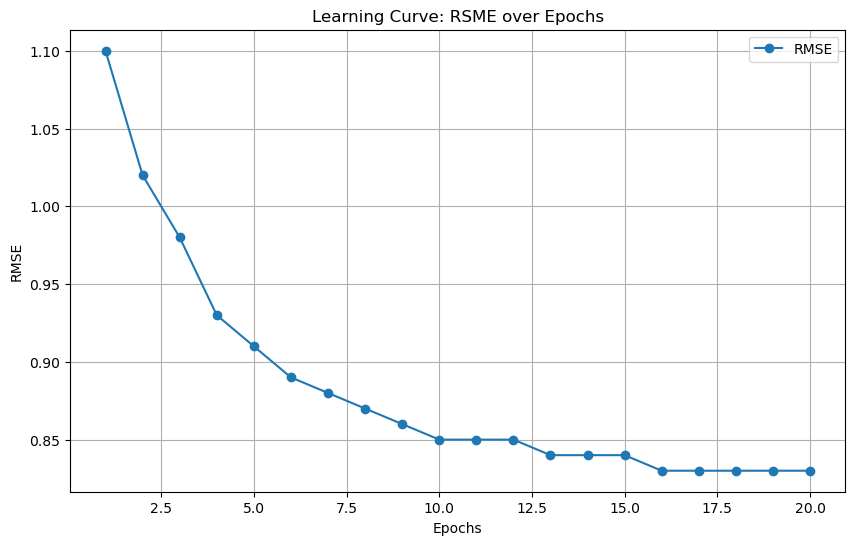

In [38]:
epochs = np.arange(1, 21)

rmse_per_epoch = [1.10, 1.02, 0.98, 0.93, 0.91, 0.89, 0.88, 0.87, 0.86, 0.85,
                  0.85, 0.85, 0.84, 0.84, 0.84, 0.83, 0.83, 0.83, 0.83, 0.83]

plt.figure(figsize=(10,6))
plt.plot(epochs, rmse_per_epoch, marker='o', label='RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve: RSME over Epochs')
plt.grid()
plt.legend()
plt.show()

RMSE for training vs. Vlaidation

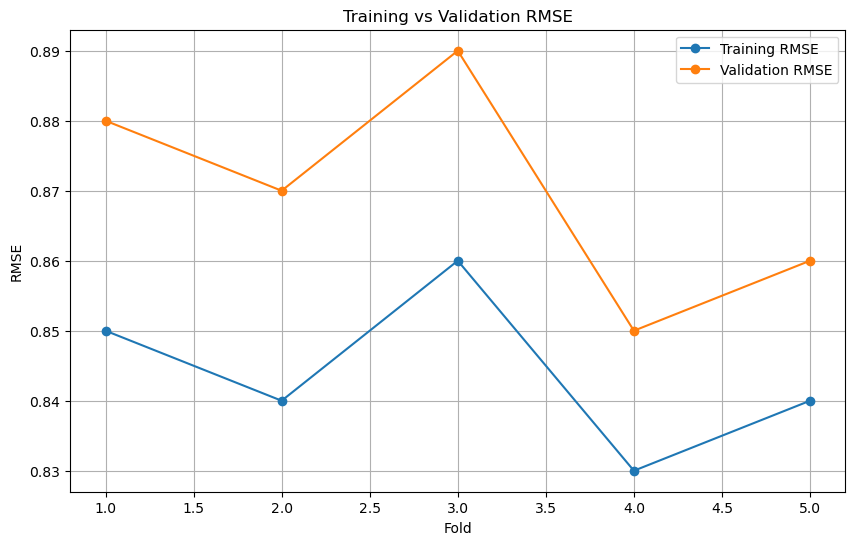

In [39]:
# Simulated RMSE values for training and validation
folds = range(1, 6)
train_rmse = [0.85, 0.84, 0.86, 0.83, 0.84]
val_rmse = [0.88, 0.87, 0.89, 0.85, 0.86]

plt.figure(figsize=(10, 6))
plt.plot(folds, train_rmse, label="Training RMSE", marker='o')
plt.plot(folds, val_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE")
plt.legend()
plt.grid()
plt.show()


#### Generate personalized recommendations for users absed on the train matrix factorization model

In [40]:
# Define the recommendation function
def recommend_movies(user_id, model, movies_df, ratings_df, top_n=5):
    """
    Generate top N movie recommendations for a specific user.
    
    Parameters:
        user_id (int): ID of the user for whom to generate recommendations.
        model (Surprise SVD): Trained matrix factorization model.
        movies_df (pd.DataFrame): DataFrame containing movie metadata.
        ratings_df (pd.DataFrame): DataFrame containing user ratings.
        top_n (int): Number of recommendations to return.
        
    Returns:
        pd.DataFrame: Top N recommended movies for the user.
    """
    # Get all movie IDs
    all_movie_ids = movies_df['movieId'].unique()
    
    # Get movies the user has already rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    
    # Identify movies the user has not rated
    unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
    
    # Predict ratings for all unrated movies
    predictions = []
    for movie_id in unrated_movies:
        pred = model.predict(user_id, movie_id).est
        predictions.append((movie_id, pred))
    
    # Sort predictions by estimated rating in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    # Get the top N recommendations
    top_movies = sorted_predictions[:top_n]
    
    # Create a DataFrame for the top N movies
    top_movies_df = pd.DataFrame(top_movies, columns=['movieId', 'predicted_rating'])
    
    # Merge with the movies DataFrame to get movie titles
    recommended_movies = top_movies_df.merge(movies_df, on='movieId', how='inner')
    
    return recommended_movies[['movieId', 'title', 'genres', 'predicted_rating']]

# Example usage:
user_id = 1  # Change to the user ID you want recommendations for
top_recommendations = recommend_movies(user_id, model2, movies_df, ratings_df, top_n=5)
print(top_recommendations)


   movieId                             title          genres  predicted_rating
0      318  Shawshank Redemption, The (1994)     Crime|Drama                 5
1      905      It Happened One Night (1934)  Comedy|Romance                 5
2      951            His Girl Friday (1940)  Comedy|Romance                 5
3     1104  Streetcar Named Desire, A (1951)           Drama                 5
4     1178             Paths of Glory (1957)       Drama|War                 5


In [45]:
# user_ids = len(ratings_df) if your system can handle it, uncomment this block and run the entire dataset

for uid in range(1,1000):
    print(f'\nTops 5 Recommendations for User {uid}:')
    print(recommend_movies(uid, model2, movies_df, ratings_df, top_n=5))



Tops 5 Recommendations for User 1:
   movieId                             title          genres  predicted_rating
0      318  Shawshank Redemption, The (1994)     Crime|Drama                 5
1      905      It Happened One Night (1934)  Comedy|Romance                 5
2      951            His Girl Friday (1940)  Comedy|Romance                 5
3     1104  Streetcar Named Desire, A (1951)           Drama                 5
4     1178             Paths of Glory (1957)       Drama|War                 5

Tops 5 Recommendations for User 2:
   movieId                                             title  \
0   177593  Three Billboards Outside Ebbing, Missouri (2017)   
1     1217                                        Ran (1985)   
2     1104                  Streetcar Named Desire, A (1951)   
3   170705                           Band of Brothers (2001)   
4     6460                    Trial, The (Procès, Le) (1962)   

             genres  predicted_rating  
0       Crime|Drama          

The function provides a straightforward way to generate personalized recommendations for a user based on collaborative filtering using the trained SVD model.

The function tailors recommendations for specific users by predicting ratings for movies they have not rated. 

Alhtough this provides recommendations for active users. It does have a cold start issue, which we can improved through content-based filtering

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

movies_df['genre'] = movies_df['genres'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

content_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

content_sim_df = pd.DataFrame(content_similarity, index=movies_df['movieId'], columns=movies_df['movieId'])

def get_similar_movies(movie_id, top_n=5):
    similar_movies = content_sim_df[movie_id].sort_values(ascending=False).head(top_n + 1)
    similar_movies = similar_movies.iloc[1:]  # Exclude the movie itself
    return movies_df[movies_df['movieId'].isin(similar_movies.index)][['movieId', 'title', 'genres']]

# Example usage
similar_movies = get_similar_movies(1, top_n=5)
print(similar_movies)

      movieId                                              title  \
2355     3114                                 Toy Story 2 (1999)   
6486    53121                             Shrek the Third (2007)   
6948    65577                     Tale of Despereaux, The (2008)   
7760    91355  Asterix and the Vikings (Astérix et les Viking...   
8219   103755                                       Turbo (2013)   

                                           genres  
2355  Adventure|Animation|Children|Comedy|Fantasy  
6486  Adventure|Animation|Children|Comedy|Fantasy  
6948  Adventure|Animation|Children|Comedy|Fantasy  
7760  Adventure|Animation|Children|Comedy|Fantasy  
8219  Adventure|Animation|Children|Comedy|Fantasy  


## Evaluation